In [48]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, \
                            compute_log_likelihood_by_week, \
                            ACTUAL_TRAJ, UNCERTAINTY_PARAMS, \
                            get_positives_by_week, get_true_positives_by_week
import sklearn 
from sklearn.preprocessing import PolynomialFeatures

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]

path2 = 'fall_2021_prior_samples:1633456006'
files2 = [f for f in listdir(path2) if isfile(join(path2, f)) and 'with_trajectories' in f ]


from vax_sims_LHS_samples import *

import numpy as np

from scipy.stats import poisson, norm

from statsmodels.api import OLS

import matplotlib.pyplot as plt 
import pandas as pd


In [53]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
    
        
        

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points


In [54]:
sampled_points2 = {}
aggregated_trajs2 = {}

count = 0
for f in files2:
    with open(join(path2, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points2[f] = point
        aggregated_trajs2[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 100 == 0:
        print("Loaded {} points".format(count))
 

Loaded 100 points
Loaded 200 points
Loaded 300 points
Loaded 400 points
Loaded 500 points
Loaded 600 points
Loaded 700 points
Loaded 800 points
Loaded 900 points
Loaded 1000 points
Loaded 1100 points
Loaded 1200 points


In [58]:
sampled_points2

{'point_0_with_trajectories.dill': [0.7807824960840362,
  0.8551522309553249,
  1.8220075618476148,
  5.29652459585583,
  0.7462126069300627,
  0.004053795258674307],
 'point_1000_with_trajectories.dill': [0.40314540611483407,
  0.48074963291541006,
  1.1708923060461274,
  4.6830784805100585,
  0.772760758277922,
  0.003423140873021483],
 'point_1001_with_trajectories.dill': [0.421053126937273,
  0.8119123213064188,
  1.6446070161476254,
  4.080056909790334,
  1.4752365604976077,
  0.004514112388043104],
 'point_1002_with_trajectories.dill': [0.37855624016299183,
  0.8018671657729646,
  1.6136540177150935,
  2.941299831665584,
  0.9736945691819322,
  0.00459567241144607],
 'point_1003_with_trajectories.dill': [0.6995240599147922,
  0.7443835425366705,
  1.7748904268629355,
  4.569687169360165,
  1.3930754802891427,
  0.003446117375958982],
 'point_1004_with_trajectories.dill': [0.7684145923783989,
  0.7574228110785366,
  1.712136368527083,
  2.24353185063185,
  1.294594548208429,
  0.0

In [55]:
def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)



In [56]:
UNCERTAINTY_PARAMS = ['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult', 'outside_infection_rate_mult',
                      'cases_isolated_per_contact_trace', 'initial_ID_prevalence']

UNCERTAINTY_PARAM_RANGES = {
    'vax_susc_mult': (0.097608, 0.941192), # 0.5194 +/- 1.96 * 0.2152
    'vax_transmission_mult': (0.25, 1),
    'contacts_per_day_mult': (0.9,2.7),
    'outside_infection_rate_mult': (1, 5),
    'cases_isolated_per_contact_trace': (0.5,1.5),
    'initial_ID_prevalence': (0.003, 0.0054)
}

means = []
sds = []

for param in UNCERTAINTY_PARAMS:
    means.append(np.mean(UNCERTAINTY_PARAM_RANGES[param]))
    sds.append((UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*1.96))
    
PARAM_MEANS = dict(zip(UNCERTAINTY_PARAMS, means))
PARAM_SDS = dict(zip(UNCERTAINTY_PARAMS, sds))


In [57]:

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += np.log(norm.pdf(scaled_log_positives))
    
    return loglik

#def compute_log_posterior()




In [64]:
sampled_points2['point_0_with_trajectories.dill']

[0.7807824960840362,
 0.8551522309553249,
 1.8220075618476148,
 5.29652459585583,
 0.7462126069300627,
 0.004053795258674307]

In [66]:

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

logliks = {}
logliks2 = {}
for f in sampled_points:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
for f in sampled_points2:
    #logliks[f] = compute_log_likelihood_by_week_(aggregated_trajs[f], eps=0)
    logliks2[f] = compute_lognormal_loglik(aggregated_trajs2[f])

/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/yz685/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [67]:
len(logliks)

1000

Text(0, 0.5, 'number of cases')

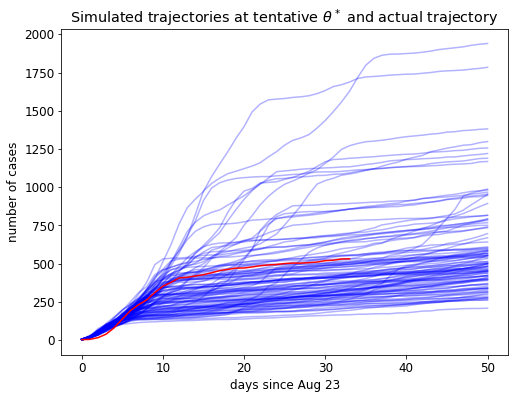

In [8]:

plt.figure(figsize=(8,6))
for i in range(len(aggregated_trajs['point_456_with_trajectories.dill'])):
    plt.plot(aggregated_trajs['point_456_with_trajectories.dill'][i], color='b', alpha=0.3)
plt.plot(np.cumsum(np.array(ACTUAL_TRAJ)), color='r')
plt.title(r'Simulated trajectories at tentative $\theta^*$ and actual trajectory')
plt.xlabel('days since Aug 23')
plt.ylabel('number of cases')

In [148]:

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks[f]) # log likelihood for corresponding param value
    
    for f in sampled_points2:
        param_vals[param].append(sampled_points2[f][idx]) # sampled parameter values
        param_logliks[param].append(logliks2[f]) # log likelihood for corresponding param value
    

Text(0.5, 1.0, 'distribution of log likelihoods using weekly aggregation')

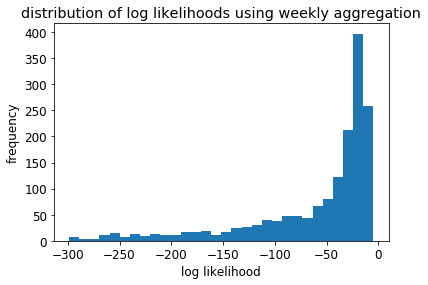

In [149]:
plt.hist([x for x in param_logliks[UNCERTAINTY_PARAMS[0]] 
          if x != float('-inf') and x >= -300], bins=30)
plt.xlabel("log likelihood")
plt.ylabel("frequency")
plt.title("distribution of log likelihoods using weekly aggregation")

In [150]:
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
#df['file_name'] = sampled_points
subdf = df
df.shape

(2213, 8)

In [151]:
df

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-102.746603,0.651268
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-251.107682,0.546052
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-25.880658,0.327567
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-1638.229519,0.991918
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-9.868776,0.458539
...,...,...,...,...,...,...,...,...
2208,0.611787,0.562578,1.207893,1.301952,0.690495,0.004305,-13.799061,0.415730
2209,0.817561,0.816224,1.459138,3.401394,1.663652,0.004356,-312.704014,0.973701
2210,0.596249,0.799402,1.997189,2.542046,0.938921,0.003825,-1638.229519,0.951945
2211,0.404840,0.504551,1.997775,1.342484,0.878451,0.004375,-14.085148,0.408070


In [152]:
log_priors = []

for row in range(df.shape[0]):
    log_prior = 0
    for param in UNCERTAINTY_PARAMS:
        log_prior += -np.log(PARAM_SDS[param]*np.sqrt(2*np.pi)) -1/2 * (df.loc[row][param]-PARAM_MEANS[param])**2/PARAM_SDS[param]**2
    log_priors.append(log_prior)


In [153]:
df['log_prior'] = log_priors
df['log_posterior'] = df['log_likelihood'] + df['log_prior']

In [154]:
df

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,log_prior,log_posterior
0,0.748766,0.833479,1.043564,2.515498,1.065157,0.006487,-102.746603,0.651268,-2.440947,-105.187550
1,0.707515,0.451851,1.708060,3.683021,0.532544,0.003432,-251.107682,0.546052,3.698319,-247.409363
2,0.778271,0.498263,0.844716,2.662501,0.470991,0.003662,-25.880658,0.327567,1.500527,-24.380130
3,0.722875,0.584793,2.346443,5.844724,0.795168,0.003987,-1638.229519,0.991918,1.752664,-1636.476855
4,0.682521,0.544387,1.234107,2.005781,1.229614,0.004297,-9.868776,0.458539,5.171231,-4.697545
...,...,...,...,...,...,...,...,...,...,...
2208,0.611787,0.562578,1.207893,1.301952,0.690495,0.004305,-13.799061,0.415730,4.086734,-9.712327
2209,0.817561,0.816224,1.459138,3.401394,1.663652,0.004356,-312.704014,0.973701,1.970122,-310.733892
2210,0.596249,0.799402,1.997189,2.542046,0.938921,0.003825,-1638.229519,0.951945,6.310111,-1631.919408
2211,0.404840,0.504551,1.997775,1.342484,0.878451,0.004375,-14.085148,0.408070,5.292701,-8.792447


In [155]:
subdf_diff = subdf[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult', \
               'log_posterior']]
#subtract from entry with largest log -- to change to posterior
subdf_diff = subdf_diff.sub(subdf_diff.iloc[subdf['log_posterior'].idxmax()])

subdf_diff = subdf_diff.dropna(subset=['log_posterior'])
subdf_diff

,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,combined_spread_mult,log_posterior
0,1.393111,-0.204330,0.002374,0.224592,-103.288954
1,2.560635,-0.736943,-0.000681,0.119377,-245.510767
2,1.540115,-0.798496,-0.000451,-0.099109,-22.481534
3,4.722338,-0.474320,-0.000126,0.565242,-1634.578259
4,0.883395,-0.039873,0.000184,0.031863,-2.798949
...,...,...,...,...,...
2208,0.179565,-0.578992,0.000192,-0.010945,-7.813731
2209,2.279008,0.394165,0.000243,0.547025,-308.835296
2210,1.419659,-0.330566,-0.000288,0.525269,-1630.020812
2211,0.220097,-0.391036,0.000262,-0.018606,-6.893851


In [156]:
subdf.iloc[subdf['log_posterior'].idxmax()]

vax_susc_mult                       0.535924
vax_transmission_mult               0.460195
contacts_per_day_mult               1.730026
outside_infection_rate_mult         1.122386
cases_isolated_per_contact_trace    1.269487
initial_ID_prevalence               0.004113
log_likelihood                     -6.450975
combined_spread_mult                0.426676
log_prior                           4.552379
log_posterior                      -1.898596
Name: 1592, dtype: float64

In [157]:
params_diff = subdf_diff[['outside_infection_rate_mult', \
               'cases_isolated_per_contact_trace', \
               'initial_ID_prevalence', \
               'combined_spread_mult']]
logposterior_diff = subdf_diff['log_posterior']
quadratic = PolynomialFeatures(degree = 2,interaction_only=False,include_bias = False)


0.40588737416820414


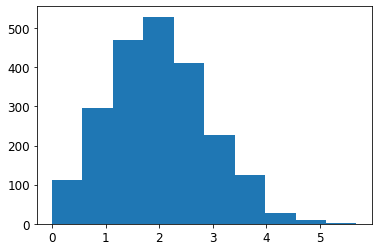

In [194]:
param_distances = np.sqrt(np.square(params_diff).sum(axis=1))

plt.hist(param_distances)
cutoff_radius = np.quantile(param_distances,0.02)
print(cutoff_radius)

In [195]:
reg_x = params_diff[param_distances < cutoff_radius]
reg_y = logposterior_diff[param_distances < cutoff_radius]
reg_x.reset_index(drop=True, inplace=True)
reg_y.reset_index(drop=True, inplace=True)

In [196]:
reg_input_quadratic = pd.DataFrame(quadratic.fit_transform(reg_x.to_numpy()),\
                                     columns = quadratic.get_feature_names(reg_x.columns))


In [197]:
norm_reg_input_quadratic = reg_input_quadratic / reg_input_quadratic.abs().max()


In [198]:
#norm_reg_input_quadratic.isnull().sum()
#np.isinf(norm_reg_input_quadratic).sum()
reg_y.isnull().sum()
#np.isinf(reg_y).sum()

0

In [199]:

model = OLS(reg_y, norm_reg_input_quadratic)
results = model.fit()

In [200]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          log_posterior   R-squared (uncentered):                   0.956
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              48.23
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                    4.49e-17
Time:                        13:42:12   Log-Likelihood:                         -143.24
No. Observations:                  45   AIC:                                      314.5
Df Residuals:                      31   BIC:                                      339.8
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
outside_infection_rate_mult                                     -4.5284      2.755     -1.644      0.110     -10.147       1.091
cases_isolated_per_contact_trace                                 0.3293      3.891      0.085      0.933      -7.607       8.265
initial_ID_prevalence                                            9.6677      3.331      2.902      0.007       2.874      16.461
combined_spread_mult                                           -17.2475      3.782     -4.560      0.000     -24.962      -9.533
outside_infection_rate_mult^2                                    2.2359      4.620      0.484      0.632      -7.187      11.658
outside_infection_rate_mult cases_isolated_per_contact_trace    -4.1175      3.418     -1.205      0.237     -11.088       2.853
outside_infection_rate_mult initial_ID_prevalence                1.9334      4.780      0.404      0.689      -7.815      11.682
outside_infection_rate_mult combined_spread_mult                -3.5642      3.421     -1.042      0.306     -10.541       3.413
cases_isolated_per_contact_trace^2                              -8.4328      5.421     -1.556      0.130     -19.488       2.623
cases_isolated_per_contact_trace initial_ID_prevalence           7.4342      5.190      1.432      0.162      -3.150      18.019
cases_isolated_per_contact_trace combined_spread_mult           10.6238      4.170      2.548      0.016       2.119      19.129
initial_ID_prevalence^2                                         -5.7702      5.943     -0.971      0.339     -17.890       6.350
initial_ID_prevalence combined_spread_mult                       9.5801      7.265      1.319      0.197      -5.237      24.398
combined_spread_mult^2                                         -99.0648      5.147    -19.247      0.000    -109.563     -88.567
==============================================================================
Omnibus:                        0.166   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.920   Jarque-Bera (JB):                0.034
Skew:                           0.063   Prob(JB):                        0.983
Kurtosis:                       2.951   Cond. No.                         6.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [201]:
results.params

outside_infection_rate_mult                                     -4.528368
cases_isolated_per_contact_trace                                 0.329290
initial_ID_prevalence                                            9.667737
combined_spread_mult                                           -17.247488
outside_infection_rate_mult^2                                    2.235898
outside_infection_rate_mult cases_isolated_per_contact_trace    -4.117503
outside_infection_rate_mult initial_ID_prevalence                1.933372
outside_infection_rate_mult combined_spread_mult                -3.564178
cases_isolated_per_contact_trace^2                              -8.432833
cases_isolated_per_contact_trace initial_ID_prevalence           7.434236
cases_isolated_per_contact_trace combined_spread_mult           10.623843
initial_ID_prevalence^2                                         -5.770229
initial_ID_prevalence combined_spread_mult                       9.580061
combined_spread_mult^2                

In [202]:
unnorm_coef = results.params / reg_input_quadratic.abs().max()

In [203]:
unnorm_coef

outside_infection_rate_mult                                    -1.165024e+01
cases_isolated_per_contact_trace                                9.117380e-01
initial_ID_prevalence                                           6.737797e+03
combined_spread_mult                                           -4.356894e+01
outside_infection_rate_mult^2                                   1.479921e+01
outside_infection_rate_mult cases_isolated_per_contact_trace   -5.864324e+01
outside_infection_rate_mult initial_ID_prevalence               9.067257e+03
outside_infection_rate_mult combined_spread_mult               -6.698711e+01
cases_isolated_per_contact_trace^2                             -6.464814e+01
cases_isolated_per_contact_trace initial_ID_prevalence          2.134526e+04
cases_isolated_per_contact_trace combined_spread_mult           1.662820e+02
initial_ID_prevalence^2                                        -2.802716e+06
initial_ID_prevalence combined_spread_mult                      2.226914e+04

In [204]:
# map regression results to hessian matrix

hessian = np.zeros((4,4))

counter = 0
for i in range(4):
    for j in range(i, 4):
        if i == j:
            hessian[i,j] = -2 * unnorm_coef[4+counter]
        else:
            hessian[i,j] = -unnorm_coef[4+counter]
        counter += 1

# fill in symmetric lower triangular part
for i in range(1,4):
    for j in range(i):
        hessian[i,j] = hessian[j,i]
    
print(hessian)

[[-2.95984122e+01  5.86432422e+01 -9.06725692e+03  6.69871093e+01]
 [ 5.86432422e+01  1.29296286e+02 -2.13452591e+04 -1.66281995e+02]
 [-9.06725692e+03 -2.13452591e+04  5.60543291e+06 -2.22691355e+04]
 [ 6.69871093e+01 -1.66281995e+02 -2.22691355e+04  1.26430456e+03]]


In [205]:
# order of parameters in the eigenvectors:
#   outside_infection_rate_mult                                     
#   cases_isolated_per_contact_trace                               
#   initial_ID_prevalence                                         
#   combined_spread_mult 

np.linalg.eig(hessian)


(array([ 5.60561734e+06, -6.09720972e+01,  1.08474947e+01,  1.22969557e+03]),
 array([[-1.61758265e-03,  8.79811065e-01, -4.74906520e-01,
          1.98411172e-02],
        [-3.80775802e-03, -4.61045732e-01, -8.62785473e-01,
         -2.07421216e-01],
        [ 9.99983548e-01, -7.91811316e-04, -4.74225481e-03,
          3.12848620e-03],
        [-3.97338357e-03, -1.15623072e-01, -1.73327828e-01,
          9.78045491e-01]]))

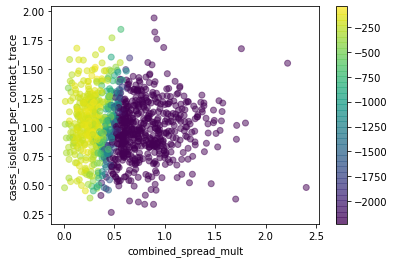

In [18]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

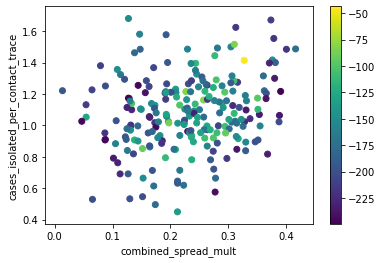

In [19]:
subdf = df[df['log_likelihood'] >= -250]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

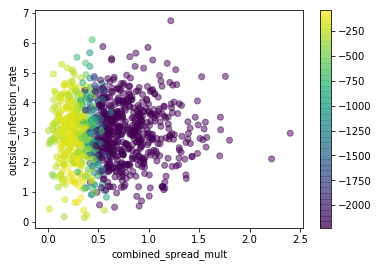

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



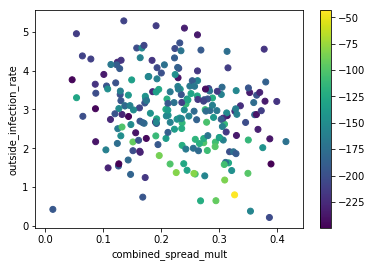

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()